## Voice Activity Detection

Inspired by the course:  
Sequence Models by deeplearning.ai

<img src="images/time_freq.png" style="width:auto;height:500px;">

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

# Data synthesis: Creating a dataset 


## 1.1 - Listening to the data   


In [3]:
IPython.display.Audio("./audio_examples/music_00025.wav")

In [4]:
IPython.display.Audio("./audio_examples/dialog_00025.wav")

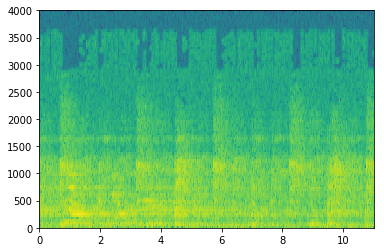

In [5]:
x = graph_spectrogram("./audio_examples/music_00025.wav")

/home/ai/anaconda3/envs/keras_tensorflow_gpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


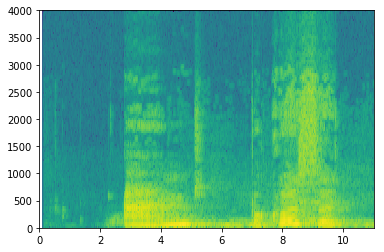

In [6]:
c_test = graph_spectrogram("./audio_examples/dialog_00025.wav")

In [7]:
rate, data_conv = wavfile.read("audio_examples/music_00025.wav")
print("Time steps in audio recording before spectrogram", data_conv.shape)         # mono
# print("Time steps in audio recording before spectrogram", data_conv[:,0].shape)  # stereo
print("rate =", rate)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (88200,)
rate = 44100
Time steps in input after spectrogram (101, 1101)


In [8]:
Tx = 1101 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [9]:
# This number is conditionned by the Conv1D(196, 15, strides=4) of the model
Ty = 272 # The number of time steps in the output of our model

## 1.3 - Generating a single training example

Because speech data is hard to acquire and label, we will synthesize the training data using the audio clips of musics, dialogs, and background noises. It is quite slow to record lots of 10 second audio clips with random dialogs in it. 

Because you had synthesized the dialog/no dialog over music and noise, we know exactly when in the 10sec clip a "dialog" occurs. This makes it easier to generate the labels $y^{\langle t \rangle}$. 

We will use the pydub package to manipulate audio. Pydub converts raw audio files into lists of Pydub data structures. Pydub uses 1ms as the discretization interval (1ms is 1 millisecond = 1/1000 seconds) which is why a 10sec clip is always represented using 10,000 steps. 

In [10]:
# Load audio segments using pydub 
dialogs, noises, musics = load_raw_audio()

print("music[0]: " + str(len(musics[0])))        # Should be 10,000, since it is a 10 sec clip
print("dialogs[0]: " + str(len(dialogs[0])))     # Between 4000 and 9000 (random length)
print("noises[0]: " + str(len(noises[0])))       # Should be 10,000, since it is a 10 sec clip

print('music 10s audio count = ', len(musics))
print('dialogs audio count = ', len(dialogs))
print('noises 10s audio count = ', len(noises))

music[0]: 2000
dialogs[0]: 2000
noises[0]: 2000
music 10s audio count =  7957
dialogs audio count =  17095
noises 10s audio count =  994


---

In [11]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
#    segment_start = np.random.randint(low=0, high=2000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
#    segment_end = segment_start + segment_ms - 1
    
#    return (segment_start, segment_end)
    return (0, segment_ms-1)

In [12]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    # Step 1: Initialize overlap as a "False" flag.
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [13]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


In [14]:
def insert_audio_clip(background, audio_clip, previous_segments=None):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 2 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed; None 
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip.
    segment_time = get_random_time_segment(segment_ms)
    
    # Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap.
    if previous_segments is not None:
        while is_overlapping(segment_time, previous_segments):
            segment_time = get_random_time_segment(segment_ms) 
        # Add the new segment_time to the list of previous_segments
        previous_segments.append(segment_time)
    
    # Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [15]:
np.random.seed(1)
audio_clip, segment_time = insert_audio_clip(musics[0], dialogs[3])
#audio_clip, segment_time = insert_audio_clip(noises[1], dialogs[1])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment Time:  (0, 1999)


In [16]:
def insert_ones(y, segment_start_ms, segment_end_ms):
    """
    Update the label vector y. The labels of the segment's output steps should be set to 1.     
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_start_ms -- the start time of the segment in ms
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_start_y = int(segment_start_ms * Ty / 2000.0)
    segment_end_y = int(segment_end_ms * Ty / 2000.0)
    
    # Add 1 to the correct index in the background label (y)
    for i in range(segment_start_y, segment_end_y + 1):
        if i < Ty:
            y[0, i] = 1
    
    return y

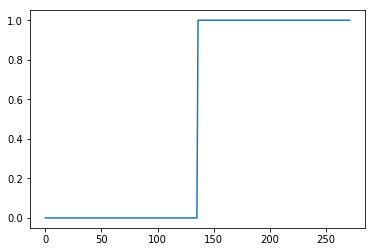

In [17]:
arr1 = insert_ones(np.zeros((1, Ty)), 1000, 2000)
plt.plot(arr1[0,:])

Finally, you can use `insert_audio_clip` and `insert_ones` to create a new training example.

**Exercise**: Implement `create_training_example()`. You will need to carry out the following steps:

1. Initialize the label vector $y$ as a numpy array of zeros and shape $(1, T_y)$.
2. Initialize the set of existing segments to an empty list.
3. Randomly select 0 to 4 "activate" audio clips, and insert them onto the 10sec clip. Also insert labels at the correct position in the label vector $y$.
4. Randomly select 0 to 2 negative audio clips, and insert them into the 10sec clip. 


In [18]:
def create_training_example(music, dialogs, noise, verbose=False):
    """
    Creates a training example with a given music, activates, and negatives.

    Arguments:
    music -- a 2 second music audio recording
    dialogs -- a list of audio segments of a conversation between two persons
    noise -- a 2 second noise audio recording

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """

    # Set the random seed
    #np.random.seed(18)

    # Make music quieter (random value up to 20 dB)
    dB_reduction = np.random.randint(0, 20)
    music = music - dB_reduction
    if verbose: print("music music -{0} dB".format(dB_reduction))

    # Initialize y (label vector) of zeros
    y = np.zeros((1, Ty))

    # Select 0 or 1 random "dialog" audio clips from the entire list of "dialogs" recordings
    number_of_dialogs = np.random.randint(0, 2)
    random_indices = np.random.randint(len(dialogs), size=number_of_dialogs)
    random_dialogs = [dialogs[i] for i in random_indices]

    # Loop over randomly selected "conversation" clips and insert in music
    for random_dialog in random_dialogs:
        # Make music quieter (random value up to 10 dB)
        dB_reduction = np.random.randint(0, 10)
        random_dialog = random_dialog - dB_reduction

        # Insert the audio clip on the music
        if verbose: print("dialog insertion... -{0} dB".format(dB_reduction))
        music, segment_time = insert_audio_clip(music, random_dialog)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_start, segment_end)
        if verbose: print("dialog inserted [{0}, {1}]".format(segment_start, segment_end))

    # insert the noise audio over music and optional dialog 
    music = music.overlay(noise, position=0)

    # Standardize the volume of the audio clip
    music = match_target_amplitude(music, -20.0)

    # Export new training example
    file_handle = music.export("train" + ".wav", format="wav")
    if verbose: print("File (train.wav) was saved in your directory.")

    # Get and plot spectrogram of the new recording (music with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")

    return x, y

music music -5 dB
dialog insertion... -8 dB
dialog inserted [0, 1999]
File (train.wav) was saved in your directory.


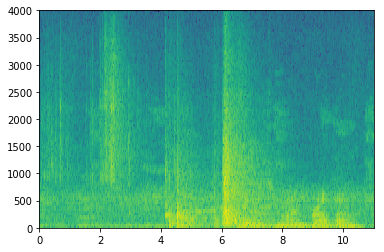

In [19]:
x, y = create_training_example(musics[1], dialogs, noises[1], verbose=True)

In [20]:
print('x.shape =', x.shape)
print('y.shape =', y.shape)

x.shape = (101, 1101)
y.shape = (1, 272)


In [21]:
print('x.transpose().shape =', x.transpose().shape)
print('y.transpose().shape =', y.transpose().shape)

x.transpose().shape = (1101, 101)
y.transpose().shape = (272, 1)


Now you can listen to the training example you created and compare it to the spectrogram generated above.

In [22]:
IPython.display.Audio("train.wav")

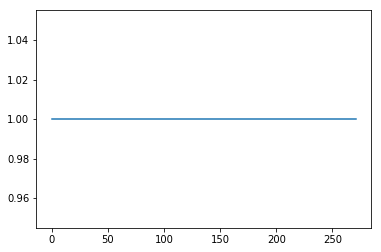

In [23]:
plt.plot(y[0])

## 1.4 - Full training set


In [24]:
def create_dev_dataset(Tx, Ty, n_freq, musics, dialogs, noises, max_samples=1500):
    print('number of music samples =', len(musics))
    n_x = min(len(musics)-1, max_samples)
    print('number of training samples =', n_x)

    X = np.zeros((n_x, Tx, n_freq))
    Y = np.zeros((n_x, Ty, 1))

    noise_index = 0
    for i in range(n_x):
        if i % 100 == 0:
            print('sample {0}/{1}'.format(i, n_x))

        x, y = create_training_example(musics[i], dialogs, noises[noise_index], verbose=False)

        X[i] = x.transpose()
        Y[i] = y.transpose()

        noise_index = noise_index + 1 if noise_index < len(noises)-1 else 0

    return X, Y

In [25]:
# create dataset
#X, Y = create_dev_dataset(Tx, Ty, n_freq, musics, dialogs, noises)
#np.save('../data/dev_set_x.npy', X)
#np.save('../data/dev_set_y.npy', Y)  

# load previously saved dev dataset
X = np.load('../data/dev_set_x.npy')
Y = np.load('../data/dev_set_y.npy')

In [26]:
X.shape

(1500, 1101, 101)

In [27]:
print('Y[2] =', Y[2])

Y[2] = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0

## 1.5 - Test set


In [28]:
def create_test_dataset(Tx, Ty, n_freq):
    with_dialog_files = glob.glob('../data/test_set/test_with_dialog_*')
    without_dialog_files = glob.glob('../data/test_set/test_without_dialog_*')

    n_x = len(with_dialog_files) + len(without_dialog_files)

    X_test = np.zeros((n_x, Tx, n_freq))
    Y_test = np.zeros((n_x, Ty, 1))

    print('number of test samples = {} ({} with and {} without dialogs)'.format(n_x, len(with_dialog_files), len(without_dialog_files)))

    sample_index = 0
    for i, audio_file in enumerate(with_dialog_files):
        print('   with dialog sample {} - {}/{}: {}'.format(sample_index, i, len(with_dialog_files), audio_file))

        x = graph_spectrogram(audio_file)

        X_test[sample_index] = x.transpose()
        Y_test[sample_index] = np.ones((Ty, 1))
        sample_index += 1

    for i, audio_file in enumerate(without_dialog_files):
        print('without dialog sample {} - {}/{}: {}'.format(sample_index, i, len(without_dialog_files), audio_file))

        x = graph_spectrogram(audio_file)

        X_test[sample_index] = x.transpose()
        Y_test[sample_index] = np.zeros((Ty, 1))
        sample_index += 1

    print('Y_test[5]  (with dialog)    =', Y_test[5])
    print('Y_test[20] (without dialog) =', Y_test[20])
    
    return X_test, Y_test

number of test samples = 181 (90 with and 91 without dialogs)
   with dialog sample 0 - 0/90: ../data/test_set/test_with_dialog_00186.wav
   with dialog sample 1 - 1/90: ../data/test_set/test_with_dialog_00142.wav
   with dialog sample 2 - 2/90: ../data/test_set/test_with_dialog_00156.wav
   with dialog sample 3 - 3/90: ../data/test_set/test_with_dialog_00129.wav
   with dialog sample 4 - 4/90: ../data/test_set/test_with_dialog_00147.wav
   with dialog sample 5 - 5/90: ../data/test_set/test_with_dialog_00137.wav
   with dialog sample 6 - 6/90: ../data/test_set/test_with_dialog_00153.wav
   with dialog sample 7 - 7/90: ../data/test_set/test_with_dialog_00143.wav
   with dialog sample 8 - 8/90: ../data/test_set/test_with_dialog_00155.wav
   with dialog sample 9 - 9/90: ../data/test_set/test_with_dialog_00168.wav
   with dialog sample 10 - 10/90: ../data/test_set/test_with_dialog_00141.wav
   with dialog sample 11 - 11/90: ../data/test_set/test_with_dialog_00125.wav
   with dialog sample 

/home/ai/anaconda3/envs/keras_tensorflow_gpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


   with dialog sample 86 - 86/90: ../data/test_set/test_with_dialog_00118.wav
   with dialog sample 87 - 87/90: ../data/test_set/test_with_dialog_00187.wav
   with dialog sample 88 - 88/90: ../data/test_set/test_with_dialog_00102.wav
   with dialog sample 89 - 89/90: ../data/test_set/test_with_dialog_00165.wav
without dialog sample 90 - 0/91: ../data/test_set/test_without_dialog_00470.wav
without dialog sample 91 - 1/91: ../data/test_set/test_without_dialog_00486.wav
without dialog sample 92 - 2/91: ../data/test_set/test_without_dialog_00487.wav
without dialog sample 93 - 3/91: ../data/test_set/test_without_dialog_00444.wav
without dialog sample 94 - 4/91: ../data/test_set/test_without_dialog_00419.wav
without dialog sample 95 - 5/91: ../data/test_set/test_without_dialog_00479.wav
without dialog sample 96 - 6/91: ../data/test_set/test_without_dialog_00459.wav
without dialog sample 97 - 7/91: ../data/test_set/test_without_dialog_00417.wav
without dialog sample 98 - 8/91: ../data/test_se

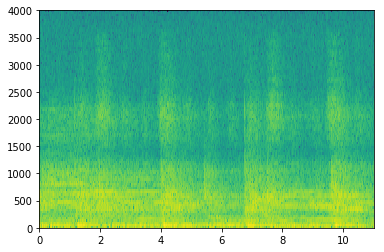

In [29]:
# create test set
X_test, Y_test = create_test_dataset(Tx, Ty, n_freq)
# np.save('../data/test_set_x.npy', X_test)
# np.save('../data/test_set_y.npy', Y_test)

# load previously saved test dataset
#X_test = np.load('../data/test_set_x.npy')
#Y_test = np.load('../data/test_set_y.npy')

---

# 2 - Model


The model will use 1-D convolutional layers, LSTM layers, and dense layers.

In [31]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

## 2.1 - Build the model

Here is the architecture (NOT A GRU BUT LSTM BI-DIRECTIONAL).

<img src="images/model.png" style="width:600px;height:600px;">
<center> **Figure 3** </center>



In [33]:
def model_lstm_bi(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # CONV layer
    X = Conv1D(196, 15, strides=4)(X_input)  # CONV1D
    X = BatchNormalization()(X)              # Batch normalization
    X = Activation('relu')(X)                # ReLu activation
    X = Dropout(0.8)(X)                      # dropout (use 0.8)

    # First LSTM Layer
    X = Bidirectional(LSTM(128, return_sequences=True))(X)  # LSTM (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                      # dropout (use 0.8)
    X = BatchNormalization()(X)              # Batch normalization
    
    # Second LSTM Layer
    X = Bidirectional(LSTM(128, return_sequences=True))(X)  # LSTM (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                      # dropout (use 0.8)
    X = BatchNormalization()(X)              # Batch normalization
    X = Dropout(0.8)(X)                      # dropout (use 0.8)
    
    # Time-distributed dense layer
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [34]:
model = model_lstm_bi(input_shape = (Tx, n_freq))

# Save the model architecture
with open('../models/lstm_bi_model_architecture.json', 'w') as f:
    f.write(model.to_json())

Let's print the model summary to keep track of the shapes.

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1101, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 272, 196)          297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 272, 196)          784       
_________________________________________________________________
activation_1 (Activation)    (None, 272, 196)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 272, 196)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 272, 256)          332800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 272, 256)          0         
__________

The output of the network is of shape (None, 1375, 1) while the input is (None, 5511, 101). The Conv1D has reduced the number of steps from 5511 at spectrogram to 1375. 

## 2.2 - Fit the model

Trigger word detection takes a long time to train. To save time, we've already trained a model for about 3 hours on a GPU using the architecture you built above, and a large training set of about 4000 examples. Let's load the model. 

You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows. This will run quickly because we are training just for one epoch and with a small training set of 26 examples. 

In [36]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

---

In [37]:
model.fit(X, Y, batch_size = 200, epochs=2)

Epoch 1/2
1500/1500 [==============================] - 8s - loss: 1.3446 - acc: 0.5118     
Epoch 2/2
1500/1500 [==============================] - 7s - loss: 1.2702 - acc: 0.5328     


In [38]:
model.fit(X, Y, batch_size = 200, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 7s - loss: 1.2128 - acc: 0.5541     
Epoch 2/10
1500/1500 [==============================] - 7s - loss: 1.1581 - acc: 0.5730     
Epoch 3/10
1500/1500 [==============================] - 7s - loss: 1.1169 - acc: 0.5902     
Epoch 4/10
1500/1500 [==============================] - 7s - loss: 1.0760 - acc: 0.6068     
Epoch 5/10
1500/1500 [==============================] - 7s - loss: 1.0530 - acc: 0.6187     
Epoch 6/10
1500/1500 [==============================] - 7s - loss: 1.0289 - acc: 0.6303     
Epoch 7/10
1500/1500 [==============================] - 7s - loss: 1.0111 - acc: 0.6377     
Epoch 8/10
1500/1500 [==============================] - 7s - loss: 0.9996 - acc: 0.6454     
Epoch 9/10
1500/1500 [==============================] - 7s - loss: 0.9881 - acc: 0.6519     
Epoch 10/10
1500/1500 [==============================] - 7s - loss: 0.9749 - acc: 0.6559     


In [39]:
model.save_weights("../models/lstm_bi_vad_20_11_2018_weights_1.h5")

---

## 2.3 - Test the model


In [40]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('../models/lstm_bi_model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

model.load_weights('../models/lstm_bi_vad_20_11_2018_weights_1.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1101, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 272, 196)          297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 272, 196)          784       
_________________________________________________________________
activation_1 (Activation)    (None, 272, 196)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 272, 196)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 272, 256)          332800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 272, 256)          0         
__________

In [41]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [42]:
loss, acc = model.evaluate(X_test, Y_test)
print("Test set accuracy = ", acc)

181/181 [==============================] - 1s     
Test set accuracy =  0.8138202814107441


---

# 3 - Making Predictions


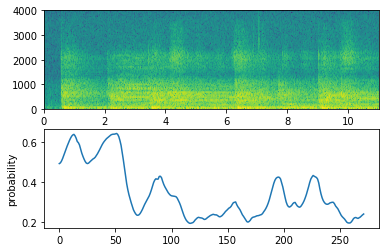

In [45]:
filename = '../data/test_set/test_with_dialog_00105.wav'
rate, data = get_wav_info(filename)

plt.subplot(2, 1, 1)  # spectrogram on top

x = graph_spectrogram(wav_file=None, rate=rate, data=data)

# the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
x = x.swapaxes(0,1)
x = np.expand_dims(x, axis=0)

predictions = model.predict(x)

plt.subplot(2, 1, 2)  # probability plot at the bottom
plt.plot(predictions[0,:,0])
plt.ylabel('probability')
plt.show()

---

# 4 - Try it LIVE!


In [67]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

In [66]:
import pyaudio
import wave

def start_live_recording(record_time = 10, output_filename = 'live_output.wav'):
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    RECORD_SECONDS = record_time
    WAVE_OUTPUT_FILENAME = output_filename

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* recording")

    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

---

In [68]:
live_output_filename = 'live_output.wav'

start_live_recording(record_time = 10, output_filename = live_output_filename)
preprocess_audio(live_output_filename)

OSError: [Errno -9996] Invalid input device (no default output device)

In [ ]:
IPython.display.Audio(live_output_filename) # listen to the audio you uploaded 